<a href="https://colab.research.google.com/github/Raghavcpp/Fraud-Detection-Model/blob/main/Fraud_Detection_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
computingvictor_transactions_fraud_datasets_path = kagglehub.dataset_download('computingvictor/transactions-fraud-datasets')

print('Data source import complete.')


Data source import complete.


### Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import time
from sklearn import metrics
from sklearn.metrics import accuracy_score

pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# Setting dataset root path:
root_dataset = computingvictor_transactions_fraud_datasets_path

### Getting Data

In [ ]:
cards_data = pd.read_csv(f"{root_dataset}/cards_data.csv")
users_data = pd.read_csv(f"{root_dataset}/users_data.csv")
transaction_data = pd.read_csv(f"{root_dataset}/transactions_data.csv")
mcc_codes = pd.read_json(f"{root_dataset}/mcc_codes.json", typ='series').reset_index().rename(columns={"index": "mcc", 0: "mcc_description"})
fraud_label_target = pd.read_json(f"{root_dataset}/train_fraud_labels.json").reset_index().rename(columns={"index": "transaction_id", "target":"fraud"})

### Merging and preprocessing the required DataFrames.

In [ ]:
# Changing strings to integers and removing '$'
cards_data['credit_limit'] = cards_data['credit_limit'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['per_capita_income'] = users_data['per_capita_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['yearly_income'] = users_data['yearly_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['total_debt'] = users_data['total_debt'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
transaction_data['amount'] = transaction_data['amount'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)

mcc_codes.mcc  = mcc_codes.mcc.astype(int)
fraud_label_target.transaction_id  = fraud_label_target.transaction_id.astype(int)
transaction_data.date = pd.to_datetime(transaction_data.date)

In [ ]:
transaction_fraud = transaction_data.merge(fraud_label_target,how='left',left_on='id', right_on='transaction_id')
transaction_fraud.drop(['id','transaction_id'],inplace=True,axis =1)

In [ ]:
main_df = transaction_fraud.merge(cards_data[['id','card_brand','card_type','has_chip']],how='left',left_on='card_id', right_on='id')
main_df.drop('id',inplace=True,axis =1)

In [ ]:
main_df['updated_amt'] = np.where(main_df.amount<0,main_df.amount*-1,main_df.amount)
main_df['fraud'] = main_df['fraud'].map({'Yes': 1, 'No': 0})
main_df.fraud.isna().sum()

np.int64(4390952)

In [ ]:
# Creating a new dataframe by grouping in order to calculate risk score for each client
client_card_df = main_df[['client_id','card_id','fraud','updated_amt']].groupby(['client_id','card_id','fraud']).agg(
        mean_amount=('updated_amt', 'mean'),
        max_amount=('updated_amt', 'max'),
        min_amount=('updated_amt', 'min'),
        total_amount=('updated_amt', 'sum'),
        count=('updated_amt', 'count')
    ).reset_index()
client_card_df.head()

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0.0,45.904068,577.46,0.65,212122.70,4621
1,0,1271,1.0,30.260000,45.48,15.04,60.52,2
2,0,4639,0.0,80.186643,1128.47,0.78,322270.12,4019
3,0,4639,1.0,70.697500,129.40,5.13,282.79,4
4,1,3682,0.0,39.487578,542.66,0.54,45331.74,1148


In [ ]:
# Aggregate fraud and total data
grouped = client_card_df.groupby(['client_id', 'card_id', 'fraud']).agg(
    fraud_count=('count', 'sum'),
    fraud_amount=('total_amount', 'sum')
).reset_index()

# Pivot to get fraud and non-fraud side by side
pivoted = grouped.pivot(index=['client_id', 'card_id'], columns='fraud', values=['fraud_count', 'fraud_amount'])
pivoted.columns = ['count_nonfraud', 'count_fraud', 'amount_nonfraud', 'amount_fraud']
pivoted = pivoted.fillna(0).reset_index()

# Calculate percentages
pivoted['fraud_count_pct'] = round(100 * pivoted['count_fraud'] / (pivoted['count_fraud'] + pivoted['count_nonfraud']),2)
pivoted['fraud_amount_pct'] = round(100 * pivoted['amount_fraud'] / (pivoted['amount_fraud'] + pivoted['amount_nonfraud']),2)


In [ ]:
pivoted.sort_values('fraud_count_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
1886,944,372,215.0,7.0,16559.83,302.10,3.15,1.79
1016,496,5806,744.0,25.0,55509.13,1953.57,3.25,3.40
3540,1746,3754,378.0,13.0,9137.06,5125.89,3.32,35.94
954,467,4481,140.0,5.0,4808.77,399.07,3.45,7.66
1553,764,1381,301.0,11.0,15931.26,518.41,3.53,3.15
1204,604,4280,281.0,11.0,5293.04,4386.14,3.77,45.32
1952,980,181,234.0,10.0,10426.70,982.01,4.10,8.61
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1524,754,2219,199.0,9.0,6271.47,680.40,4.33,9.79
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45


In [ ]:
pivoted.sort_values('fraud_amount_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
3428,1694,5032,1252.0,19.0,22950.16,2953.21,1.49,11.40
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1687,840,4992,264.0,5.0,8744.63,1199.46,1.86,12.06
3716,1833,2345,341.0,6.0,18923.75,2815.74,1.73,12.95
3939,1942,246,1607.0,5.0,8350.50,1254.38,0.31,13.06
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45
2024,1016,5883,501.0,8.0,9896.90,1992.37,1.57,16.76
3918,1928,2442,894.0,19.0,11905.08,2828.68,2.08,19.20
2981,1492,2171,560.0,9.0,4755.17,1461.11,1.58,23.50
2188,1102,3952,1413.0,37.0,20193.51,7097.85,2.55,26.01


In [ ]:
# Function to calculate risk score
def compute_risk_score(row):
    fraud_amt_threshold = pivoted[pivoted['fraud_count_pct']>0]['amount_fraud'].quantile(0.75)
    fraud_cnt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_count_pct'].quantile(0.75)
    fraud_amt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_amount_pct'].quantile(0.75)
    score = 0
    if row['fraud_count_pct'] > fraud_cnt_pct_threshold:
        score += 1
    if row['fraud_amount_pct'] > fraud_amt_pct_threshold:
        score += 1
    if row['amount_fraud'] > fraud_amt_threshold:
        score += 1
    return score

In [ ]:
pivoted['risk_score'] = pivoted.apply(compute_risk_score, axis=1)

In [ ]:
main_df = main_df.merge(pivoted.rename(columns={'card_id': 'cc_id'})[['risk_score', 'cc_id']],how='left',left_on='card_id',right_on='cc_id')
main_df.drop('cc_id',inplace=True,axis =1)
main_df.head()

,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,fraud,card_brand,card_type,has_chip,updated_amt,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,0.0,Mastercard,Debit (Prepaid),YES,77.00,3.0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,0.0,Mastercard,Credit,YES,14.57,0.0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,0.0,Mastercard,Debit,YES,80.00,0.0
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,NaN,Mastercard,Debit,NO,200.00,0.0
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,0.0,Visa,Debit,YES,46.41,2.0


In [ ]:
main_df.shape

(13305915, 17)

In [ ]:
main_df

,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,fraud,card_brand,card_type,has_chip,updated_amt,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,0.0,Mastercard,Debit (Prepaid),YES,77.00,3.0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,0.0,Mastercard,Credit,YES,14.57,0.0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,0.0,Mastercard,Debit,YES,80.00,0.0
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,NaN,Mastercard,Debit,NO,200.00,0.0
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,0.0,Visa,Debit,YES,46.41,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN,0.0,Mastercard,Debit,YES,1.11,0.0
13305911,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN,0.0,Mastercard,Debit,YES,12.80,3.0
13305912,2019-10-31 23:57:00,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN,0.0,Mastercard,Debit,YES,40.44,0.0
13305913,2019-10-31 23:58:00,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN,NaN,Visa,Debit,YES,4.00,0.0


In [ ]:
# Enconding the objects to integer types
label_encoder = LabelEncoder()
main_df['card_brand']= label_encoder.fit_transform(main_df['card_brand'])
main_df['card_type']= label_encoder.fit_transform(main_df['card_type'])
main_df['has_chip']= label_encoder.fit_transform(main_df['has_chip'])
main_df['merchant_state']= label_encoder.fit_transform(main_df['merchant_state'])
main_df['merchant_city']= label_encoder.fit_transform(main_df['merchant_city'])
main_df['errors']= label_encoder.fit_transform(main_df['errors'])
main_df['zip']= label_encoder.fit_transform(main_df['zip'])


In [ ]:
# Columns who have better correlation with fraud
columns = ['amount', 'merchant_state', 'merchant_city', 'mcc','errors','zip','has_chip','card_type','card_brand','fraud']
main_df = main_df[columns]
main_df.head()

,amount,merchant_state,merchant_city,mcc,errors,zip,has_chip,card_type,card_brand,fraud
0,-77.00,117,842,5499,22,15525,1,2,2,0.0
1,14.57,67,841,5311,22,14142,1,0,2,0.0
2,80.00,24,11626,4829,22,22949,1,1,2,0.0
3,200.00,70,2526,4829,22,12374,0,1,2,NaN
4,46.41,94,4711,5813,22,4973,1,1,3,0.0


In [ ]:
# Separating the data who have 'null' in fraud
final_test_df = main_df[main_df.fraud.isna()].drop('fraud',axis =1)
print(final_test_df.shape)
final_test_df.head()

(4390952, 9)


,amount,merchant_state,merchant_city,mcc,errors,zip,has_chip,card_type,card_brand
3,200.00,70,2526,4829,22,12374,0,1,2
6,77.00,117,842,5499,22,15525,1,2,2
8,261.58,199,8040,7801,22,25256,1,1,3
9,10.74,123,3739,5813,22,2349,1,2,2
15,1.09,171,9851,5942,22,20562,1,1,2


In [ ]:
train_df = main_df[main_df['fraud'].notna()]
print(train_df.shape)
train_df.head()

(8914963, 10)


,amount,merchant_state,merchant_city,mcc,errors,zip,has_chip,card_type,card_brand,fraud
0,-77.00,117,842,5499,22,15525,1,2,2,0.0
1,14.57,67,841,5311,22,14142,1,0,2,0.0
2,80.00,24,11626,4829,22,22949,1,1,2,0.0
4,46.41,94,4711,5813,22,4973,1,1,3,0.0
5,4.81,123,1265,5942,22,2146,1,2,2,0.0


In [ ]:
sampled_df, _ = train_test_split(train_df, train_size=2_000_000, stratify=train_df['fraud'], random_state=42)
X = sampled_df.drop(columns=['fraud'])
y = sampled_df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#1 Random Forest
random = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

#2 XGB Clsddifier
xgb = XGBClassifier(scale_pos_weight=99.6/0.4, random_state=42)

#3 Decision Tree
dtree =  DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2)

#4 KNN
knn = KNeighborsClassifier()

#5 Gradient Boosting
gb=GradientBoostingClassifier()

#6 Voting Hard
voting_hard = VotingClassifier(
    estimators=[('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")), ('xg_boost', XGBClassifier(scale_pos_weight=99.6/0.4, random_state=42)),('desicion_tree=',   DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2))],
    voting='hard')

#7 Voting Soft
voting_soft = VotingClassifier(
    estimators=[('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")), ('xg_boost', XGBClassifier(scale_pos_weight=99.6/0.4, random_state=42)),('desicion_tree=',   DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2))],
    voting='soft')

cv_dict = {0: 'Random Forest', 1:'XGB Classifier', 2: 'Decision Tree', 3: 'K Nearest Neighbors', 4: 'Gradient Boosting', 5:'Voting Hard', 6:'Voting Soft'}
cv_models=[random,xgb,dtree,knn,gb,voting_hard,voting_soft]

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score','ROC-AUC Score','MCC','Time','Correct Lables Predicted (1782993)'])

for i,model in enumerate(cv_models):

    print('------------------------------------------------------------------------\n')

    start_time = time.time()
    print(f"Train Accuracy :",cv_dict.get(i))

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    end_time = time.time()
    confusion =  metrics.confusion_matrix(y_test, y_pred)

    metrics_df.loc[len(metrics_df)] = [
        cv_dict[i],
        round(accuracy_score(y_test, y_pred),3),
        round(metrics.precision_score(y_test, y_pred),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(metrics.f1_score(y_test, y_pred),3),
        round(metrics.roc_auc_score(y_test, y_pred),3),
        round(metrics.matthews_corrcoef(y_test,y_pred),3),
        end_time - start_time,
        confusion[0][0] + confusion[1][1]
    ]


------------------------------------------------------------------------

Train Accuracy : Random Forest
------------------------------------------------------------------------

Train Accuracy : XGB Classifier
------------------------------------------------------------------------

Train Accuracy : Decision Tree
------------------------------------------------------------------------

Train Accuracy : K Nearest Neighbors
------------------------------------------------------------------------

Train Accuracy : Gradient Boosting
------------------------------------------------------------------------

Train Accuracy : Voting Hard
------------------------------------------------------------------------

Train Accuracy : Voting Soft


In [ ]:
metrics_df.sort_values('MCC')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score,MCC,Time,Correct Lables Predicted (1782993)
1,XGB Classifier,0.987,0.092,0.847,0.166,0.917,0.276,12.823207,394803
4,Gradient Boosting,0.998,0.361,0.360,0.360,0.679,0.360,233.321821,399223
3,K Nearest Neighbors,0.999,0.662,0.255,0.368,0.627,0.410,283.901425,399467
0,Random Forest,0.999,0.696,0.539,0.607,0.769,0.612,401.976251,399576
5,Voting Hard,0.999,0.700,0.583,0.636,0.791,0.638,342.731101,399594
2,Decision Tree,0.999,0.924,0.460,0.614,0.730,0.651,7.170185,399648
6,Voting Soft,0.999,0.711,0.621,0.663,0.810,0.664,326.527149,399615


In [ ]:
metrics_df.sort_values('Correct Lables Predicted (1782993)')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score,MCC,Time,Correct Lables Predicted (1782993)
1,XGB Classifier,0.987,0.092,0.847,0.166,0.917,0.276,12.823207,394803
4,Gradient Boosting,0.998,0.361,0.360,0.360,0.679,0.360,233.321821,399223
3,K Nearest Neighbors,0.999,0.662,0.255,0.368,0.627,0.410,283.901425,399467
0,Random Forest,0.999,0.696,0.539,0.607,0.769,0.612,401.976251,399576
5,Voting Hard,0.999,0.700,0.583,0.636,0.791,0.638,342.731101,399594
6,Voting Soft,0.999,0.711,0.621,0.663,0.810,0.664,326.527149,399615
2,Decision Tree,0.999,0.924,0.460,0.614,0.730,0.651,7.170185,399648


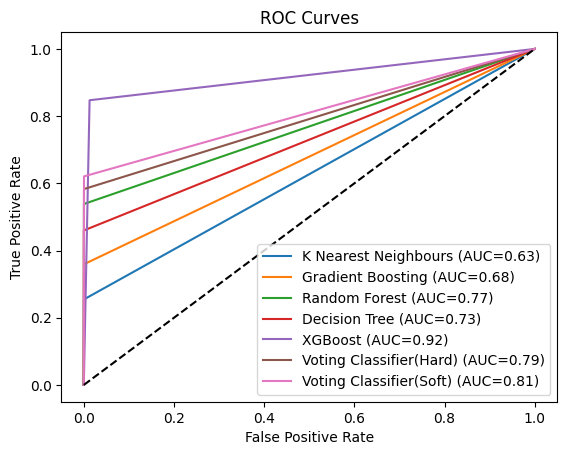

In [ ]:
# ROC Curve for each classifier
from sklearn.metrics import roc_curve, auc
models = [
    knn,
    gb,
    random,
    dtree,
    xgb,
    voting_hard,
    voting_soft
]

y_preds = [model.predict(X_test) for model in models]

roc_curves = [roc_curve(y_test, y_pred) for y_pred in y_preds]
auc_scores = [auc(roc_curve[0], roc_curve[1]) for roc_curve in roc_curves]
model_name = ['K Nearest Neighbours','Gradient Boosting', 'Random Forest', 'Decision Tree', 'XGBoost', 'Voting Classifier(Hard)', 'Voting Classifier(Soft)']

fig, ax = plt.subplots()
for roc_curve, auc_score, model_name in zip (roc_curves,auc_scores,model_name):
    ax.plot(roc_curve[0], roc_curve[1], label=f"{model_name} (AUC={auc_score:.2f})")

plt.plot([0, 1], [0, 1.0], '--', color='black')


ax.set_title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

plt.show()

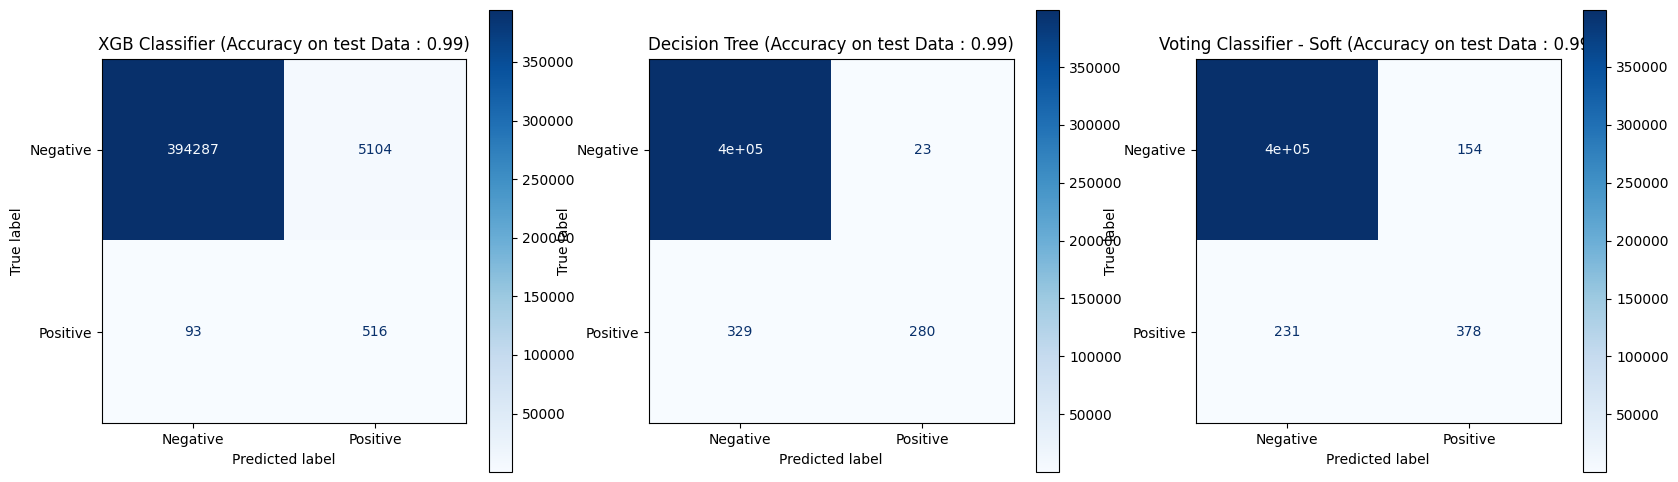

In [ ]:
 fig, ax = plt.subplots(1,3, figsize = (20,6))
ax[0].set_title("XGB Classifier (Accuracy on test Data : 0.99)")
ax[1].set_title("Decision Tree (Accuracy on test Data : 0.99)")
ax[2].set_title("Voting Classifier - Soft (Accuracy on test Data : 0.99)")


confusion_matrix = metrics.confusion_matrix(y_test, xgb.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])
cm_display.plot(ax = ax[0], cmap='Blues')

confusion_matrix = metrics.confusion_matrix(y_test, dtree.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])
cm_display.plot(ax = ax[1], cmap='Blues')

confusion_matrix = metrics.confusion_matrix(y_test, voting_soft.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])
cm_display.plot(ax = ax[2], cmap='Blues')

plt.show()